In [31]:
import astropy.constants as const
import astropy.units as u
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from plotting import label_axes
from utils import GeV_over_c

# Primary CR


In [32]:
F_UNIT = u.pc ** (-3) * GeV_over_c ** (-3)
Q_UNIT = F_UNIT / u.kyr
GV = u.def_unit(
    "GV",
    u.GeV / (const.e.gauss * const.c),
    format={"latex": r"GV"},
    prefixes=False,
)

In [33]:
# injection
gamma = 4.3  # must bee >4 to avoid logarithmic divergence
eps_CR = 0.1
E_SN = 1e52 * u.erg
R_SN = 1 / (50 * u.yr)
R_d = 10 * u.kpc
E0 = 5 * u.GeV
log10E0 = np.log10(E0.to(u.GeV).value)

Q0 = ((gamma - 4) * eps_CR * E_SN * R_SN * const.c**3) / (4 * np.pi**2 * R_d**2 * E0**4)
Q = lambda E: Q0 * (E / E0) ** (-gamma)

In [34]:
# galactic environment
D0 = 1e28 * u.cm**2 / u.s
delta = 1 / 3
D = lambda R: D0 * (R.to(GV).value) ** delta

H = 3 * u.kpc
h = 100 * u.pc
n_d = 1 * u.cm ** (-3)
n_avg = n_d * h / H

chi = lambda R: (const.m_p * n_avg * const.c * (H**2) / D(R)).to(u.g / u.cm**2)

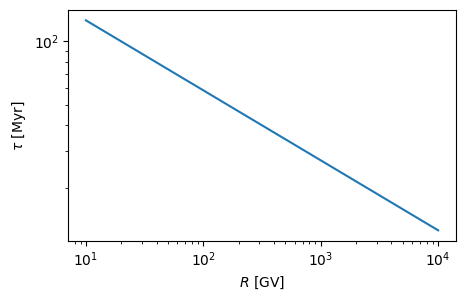

In [35]:
fig, ax = plt.subplots(figsize=(5, 3))

R_grid = np.logspace(1, 4, 100) * GV
ax.loglog(R_grid, (H**2 / D(R_grid)).to(u.Myr))

label_axes(ax, "R", "\\tau")

plt.show()

In [36]:
# particle physics
sigma_p = 45 * u.mbarn
sigma = lambda A: sigma_p * A ** (2 / 3)

chi_crit = lambda A: const.m_p / sigma(A)

In [37]:
nuclei = ((1, 1, "H"), (12, 6, "C"), (16, 8, "O"), (56, 26, "Fe"))
cmap = matplotlib.colormaps["turbo"]

/var/folders/pt/5p7r1p1j49n8f_88l1j7jtwc0000gn/T/ipykernel_11795/3155789948.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


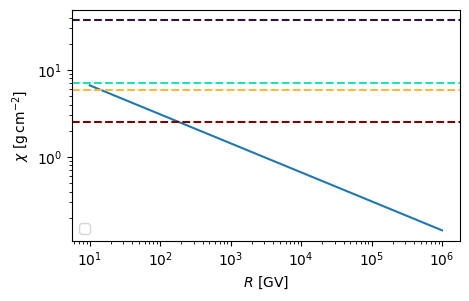

In [38]:
fig, ax = plt.subplots(figsize=(5, 3))

R_grid = np.logspace(1, 6, 100) * GV
ax.loglog(R_grid, chi(R_grid))

for idx, (A, Z, nucl) in enumerate(nuclei):
    color = cmap(idx / (len(nuclei) - 1))
    ax.axhline(chi_crit(A), color=color, linestyle="--")

label_axes(ax, "R", "\\chi")
ax.legend()
plt.show()

In [39]:
def E(R: u.Quantity[GV], Z: int) -> u.Quantity[u.GeV]:
    return (Z * const.e.gauss * const.c * R_grid).to(u.GeV)


def f_primary(R_grid: u.Quantity[GV], A: int, Z: int) -> u.Quantity[F_UNIT]:
    E_grid = E(R_grid, Z)
    # print(E_grid)
    return (Q(E_grid) / ((2 * D(R_grid) / H) * (1 + chi(R_grid) / chi_crit(A)))).to(
        F_UNIT
    )


def f_primary_nonspallating(R_grid: u.Quantity[GV], Z: int) -> u.Quantity[F_UNIT]:
    E_grid = E(R_grid, Z)
    return (Q(E_grid) / ((2 * D(R_grid) / H))).to(F_UNIT)

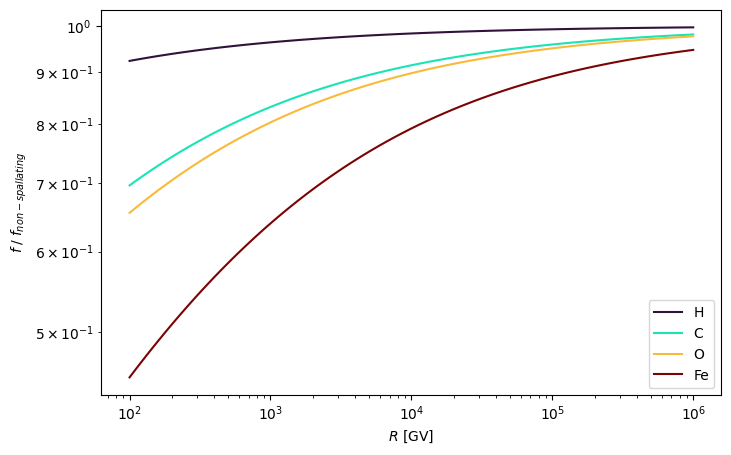

In [40]:
fig, ax = plt.subplots(figsize=(8, 5))

R_grid = np.logspace(2, 6, 100) * GV

for idx, (A, Z, nucl) in enumerate(nuclei):
    ax.loglog(
        R_grid,
        f_primary(R_grid, A, Z) / f_primary_nonspallating(R_grid, Z),
        label=nucl,
        color=cmap(idx / (len(nuclei) - 1)),
    )

cmap = matplotlib.colormaps["turbo"]
label_axes(ax, "R", "f \\; / \\; f_{non-spallating}")
ax.legend()
plt.show()

# Secondary CR

Specifically, B as secondary from C spallation


In [41]:
# C -> B branching ratio (reverse engineered from expected 0.3)
K_C2B = 0.3 * sigma(11) / sigma(12)

In [42]:
def f_secondary(
    R_grid: u.Quantity[GV],
    A: int,
    Z: int,
    A_parent: int,
    Z_parent: int,
    K: float,
) -> u.Quantity[F_UNIT]:
    jacobian = A_parent / A
    E_grid = E(R_grid, Z)
    R_grid_parent = (jacobian * E_grid / (Z_parent * const.e.gauss * const.c)).to(GV)
    f_primary_shifted = f_primary(R_grid_parent, A=A_parent, Z=Z_parent) * jacobian**3
    # print(E_grid)
    return (
        (1 / (chi_crit(A_parent) / K))
        / (1 / chi(R_grid) + 1 / chi_crit(A))
        * f_primary_shifted
    ).to(F_UNIT)

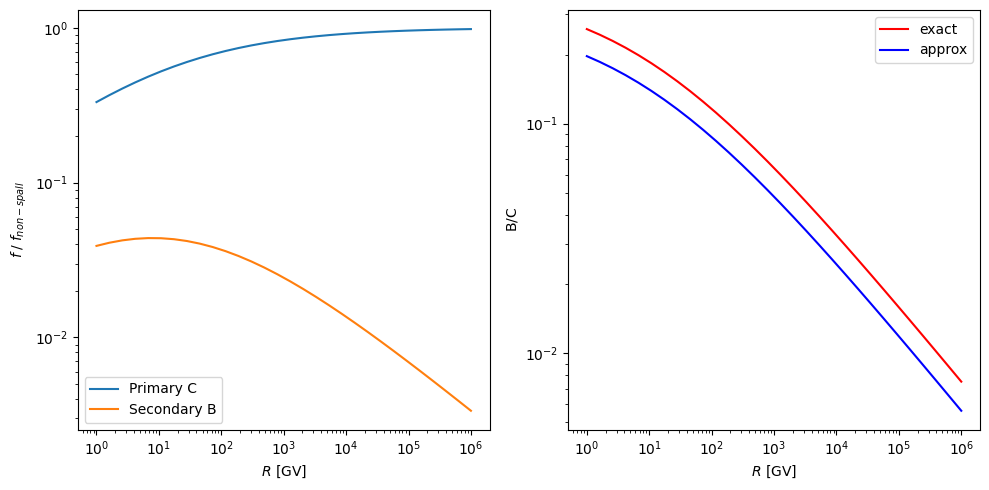

In [43]:
fig, axes = plt.subplots(figsize=(10, 5), ncols=2)
ax = axes[0]
ax2 = axes[1]

R_grid = np.logspace(0, 6, 30) * GV

A_C = 12
Z_C = 6
A_B = 11
Z_B = 5

C = f_primary(R_grid, A_C, Z_C)
ax.loglog(R_grid, C / f_primary_nonspallating(R_grid, Z=Z_C), label="Primary C")
B = f_secondary(R_grid, A=A_B, Z=Z_B, A_parent=A_C, Z_parent=Z_C, K=K_C2B)
ax.loglog(R_grid, B / f_primary_nonspallating(R_grid, Z=Z_B), label="Secondary B")
label_axes(ax, "R", "f \\; / \\; f_{non-spall}")

ax2.loglog(R_grid, B / C, label="exact", color="r")
B_over_C_approx = (chi(R_grid) / (chi_crit(A_C) / K_C2B)) / (
    1 + chi(R_grid) / chi_crit(A_B)
)
ax2.loglog(R_grid, B_over_C_approx, label="approx", color="b")
ax2.legend()
label_axes(ax2, "R", "\\mathrm{B / C}")

ax.legend()
plt.tight_layout()
plt.show()

# Unstable secondary


In [44]:
def f_secondary_unstable(
    R_grid: u.Quantity[GV],
    A: int,
    Z: int,
    A_parent: int,
    Z_parent: int,
    K: float,
    tau_dec: u.Quantity[u.yr],
) -> u.Quantity[F_UNIT]:
    E_grid = E(R_grid, Z)

    m = Z * const.m_p + (A - Z) * const.m_n
    gamma = (E_grid / (m * const.c**2)).decompose()
    alpha = 1 / np.sqrt(gamma * tau_dec * D(R_grid))
    y = np.exp(alpha * H)
    chi_modified = chi(R_grid) / (H * alpha * (y**2 + 1) / (y**2 - 1))

    jacobian = A_parent / A
    R_grid_parent = (jacobian * E_grid / (Z_parent * const.e.gauss * const.c)).to(GV)
    f_primary_shifted = f_primary(R_grid_parent, A=A_parent, Z=Z_parent) * jacobian**3
    return (
        (1 / (chi_crit(A_parent) / K))
        / (1 / chi_modified + 1 / chi_crit(A))
        * f_primary_shifted
    ).to(F_UNIT)

/var/folders/pt/5p7r1p1j49n8f_88l1j7jtwc0000gn/T/ipykernel_11795/2174053047.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


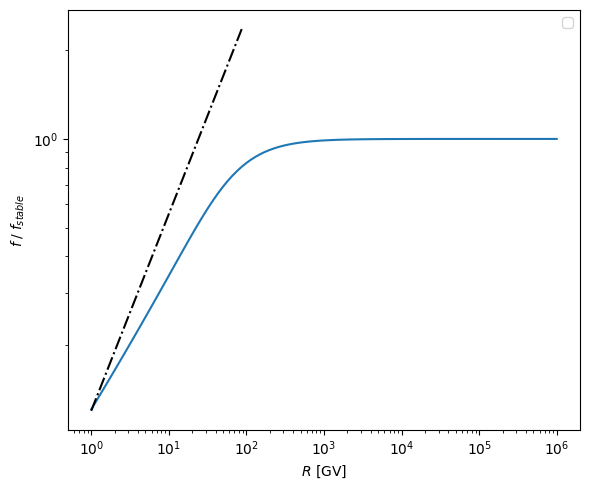

In [64]:
fig, ax = plt.subplots(figsize=(6, 5))

R_grid = np.logspace(0, 6, 100) * GV

A_C = 12
Z_C = 6
A_Be = 9
Z_Be = 4
K_C2Be = 0.3

Be_stable = f_secondary(
    R_grid,
    A=A_Be,
    Z=Z_Be,
    A_parent=A_C,
    Z_parent=Z_C,
    K=K_C2Be,
)
Be_unstable = f_secondary_unstable(
    R_grid,
    A=A_Be,
    Z=Z_Be,
    A_parent=A_C,
    Z_parent=Z_C,
    K=K_C2Be,
    tau_dec=1.39 * u.Myr,
)

ax.loglog(R_grid, Be_unstable / Be_stable)

imax = len(R_grid) // 3
ax.loglog(
    R_grid[:imax],
    1.2e-1 * (R_grid[:imax] / (1 * GV)) ** ((1 + delta) / 2),
    color="k",
    linestyle="-.",
)

label_axes(ax, "R", "f \\; / \\; f_{stable}")

ax.legend()
plt.tight_layout()
plt.show()